In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
task_names = ['Linear (1)','Linear (2)','Checker'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])[0:3,:]

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_trainrepeat.npy')
dec_trainrepeat = np.load(save_filename, allow_pickle=True).item()
dec_trainrepeat.keys()

dict_keys(['acc_bytask', 'dprime_bytask', 'preds_all', 'probs_all', 'acc_each_cval', 'best_cval', 'roi_names'])

In [5]:
roi_names = dec_trainrepeat['roi_names']
n_rois = len(roi_names)

#### accuracy along each linear axis, in each task

In [6]:
conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            # actual labels for position along this axis
            coord_actual = pt_labs[:,ii]
            # actual category along this axis
            categ_actual = np.array(l['categ_task%d'%(ii+1)])
    
            dist_from_center = np.array(l['dist_from_bound%d'%(ii+1)]).round(1)
            # hard trials are closest to bound (variable grid)
            # easy is the furthest from bound
            # medium is second furthest
            is_hard = dist_from_center<0.8
            is_easy = (dist_from_center==2.4) & is_main_grid
            is_medium = (dist_from_center==0.8) & is_main_grid
           
            is_correct = np.array(l['subject_correct'])
            
            for ri in range(n_rois):

                # switching categs here so that 1=coord<center, 2=coord>center
                categ_pred = 3-dec_trainrepeat['preds_all'][si][ri][ti][ii].astype(int)
             
                prob = dec_trainrepeat['probs_all'][si][ri][ti][ii]
                
                p_categ1 = prob[:,1]
                p_categ2 = prob[:,0]
                
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

    
                # all trials
                inds = is_main_grid & is_correct
            
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # easy trials
                inds = is_easy & is_correct
                
                conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_medium & is_correct
                
                conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                

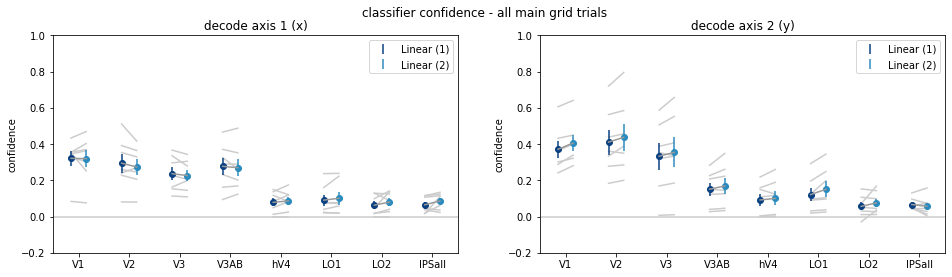

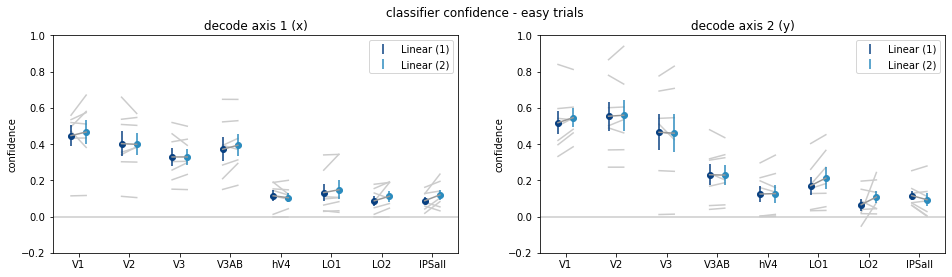

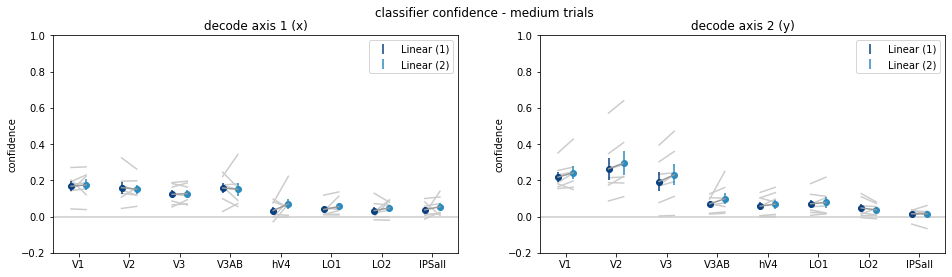

In [7]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15, 2)

for rvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([-0.2, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('classifier confidence - %s'%name)


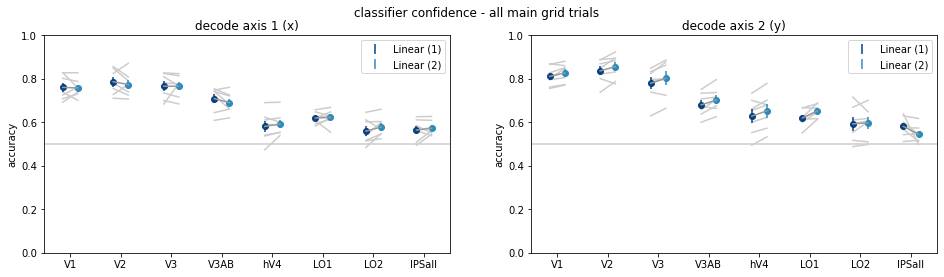

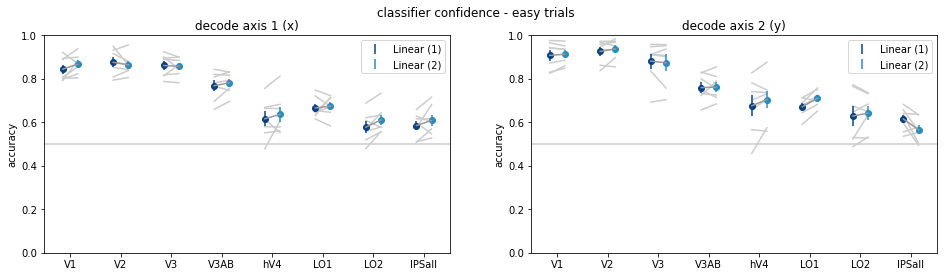

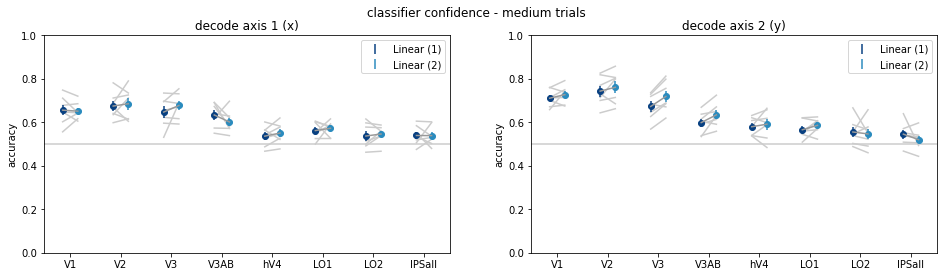

In [8]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15, 2)

for rvals, name in zip([acc_allmaintrials, acc_easytrials, acc_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(1/2, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([0,1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('accuracy')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('classifier confidence - %s'%name)
